<a href="https://colab.research.google.com/github/tanishq507/finence/blob/main/BitcoinPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import xgboost as xgb
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.dates as mdates
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Uploading the training data

# New section

In [16]:
train = pd.read_csv('BTC-INR_TrainingData.csv')
print(train.shape)
train.head()

# bitcoinDatainINR=yahooFinance.Ticker('BTC-INR')
# startDate = datetime.datetime(2014, 10, 1)
# endDate = datetime.datetime(2023, 2, 28)
# print(bitcoinDatainINR.history(start=startDate, end=endDate))

(2953, 8)


,S. No.,Date,Open,High,Low,Close,Adj Close,Volume
0,1,01-10-2014,23991.41797,24200.91992,23497.93359,23672.88086,23672.88086,1.618616e+09
1,2,02-10-2014,23695.90039,23765.89063,22949.23242,23080.05469,23080.05469,1.340091e+09
2,3,03-10-2014,23086.76367,23241.46289,22020.85352,22122.57031,22122.57031,1.901505e+09
3,4,04-10-2014,22145.95508,22428.70703,20053.39453,20236.76953,20236.76953,2.906698e+09
4,5,05-10-2014,20239.84570,21032.72461,17801.82813,19722.58398,19722.58398,5.126364e+09


In [17]:
print(train.info())
train.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2953 entries, 0 to 2952
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   S. No.     2953 non-null   int64  
 1   Date       2953 non-null   object 
 2   Open       2953 non-null   float64
 3   High       2953 non-null   float64
 4   Low        2953 non-null   float64
 5   Close      2953 non-null   float64
 6   Adj Close  2953 non-null   float64
 7   Volume     2953 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 184.7+ KB
None


,S. No.,Open,High,Low,Close,Adj Close,Volume
count,2953.000000,2.953000e+03,2.953000e+03,2.953000e+03,2.953000e+03,2.953000e+03,2.953000e+03
mean,1477.000000,9.441955e+05,9.680330e+05,9.177244e+05,9.446466e+05,9.446466e+05,1.191550e+12
std,852.601998,1.224860e+06,1.255750e+06,1.189359e+06,1.224549e+06,1.224549e+06,1.480376e+12
min,1.000000,1.098354e+04,1.309874e+04,1.064906e+04,1.105842e+04,1.105842e+04,3.628589e+08
25%,739.000000,4.515582e+04,4.584503e+04,4.408456e+04,4.515704e+04,4.515704e+04,6.655020e+09
50%,1477.000000,4.850878e+05,4.998585e+05,4.778388e+05,4.866314e+05,4.866314e+05,4.644060e+11
75%,2215.000000,1.055988e+06,1.121726e+06,1.016295e+06,1.065562e+06,1.065562e+06,2.074150e+12
max,2953.000000,4.993192e+06,5.109432e+06,4.920109e+06,4.994456e+06,4.994456e+06,2.583000e+13


In [18]:
train.index = pd.to_datetime(train['Date'])#train.index now considers only year part of the date
train = train.iloc[:,2:6] # had to drop some useful features to match the test data
train

,Open,High,Low,Close
Date,,,,
2014-01-10,2.399142e+04,2.420092e+04,2.349793e+04,2.367288e+04
2014-02-10,2.369590e+04,2.376589e+04,2.294923e+04,2.308005e+04
2014-03-10,2.308676e+04,2.324146e+04,2.202085e+04,2.212257e+04
2014-04-10,2.214596e+04,2.242871e+04,2.005339e+04,2.023677e+04
2014-05-10,2.023985e+04,2.103272e+04,1.780183e+04,1.972258e+04
...,...,...,...,...
2022-10-27,1.704405e+06,1.715532e+06,1.669907e+06,1.672418e+06
2022-10-28,1.672593e+06,1.706401e+06,1.656229e+06,1.694744e+06
2022-10-29,1.694724e+06,1.727087e+06,1.692369e+06,1.713104e+06


In [19]:
def create_features(df):
  df['dayofweek'] = df.index.day_of_week
  df['month'] = df.index.month
  df['dayofyear'] = df.index.dayofyear
  return df
train = create_features(train)
train

,Open,High,Low,Close,dayofweek,month,dayofyear
Date,,,,,,,
2014-01-10,2.399142e+04,2.420092e+04,2.349793e+04,2.367288e+04,4,1,10
2014-02-10,2.369590e+04,2.376589e+04,2.294923e+04,2.308005e+04,0,2,41
2014-03-10,2.308676e+04,2.324146e+04,2.202085e+04,2.212257e+04,0,3,69
2014-04-10,2.214596e+04,2.242871e+04,2.005339e+04,2.023677e+04,3,4,100
2014-05-10,2.023985e+04,2.103272e+04,1.780183e+04,1.972258e+04,5,5,130
...,...,...,...,...,...,...,...
2022-10-27,1.704405e+06,1.715532e+06,1.669907e+06,1.672418e+06,3,10,300
2022-10-28,1.672593e+06,1.706401e+06,1.656229e+06,1.694744e+06,4,10,301
2022-10-29,1.694724e+06,1.727087e+06,1.692369e+06,1.713104e+06,5,10,302


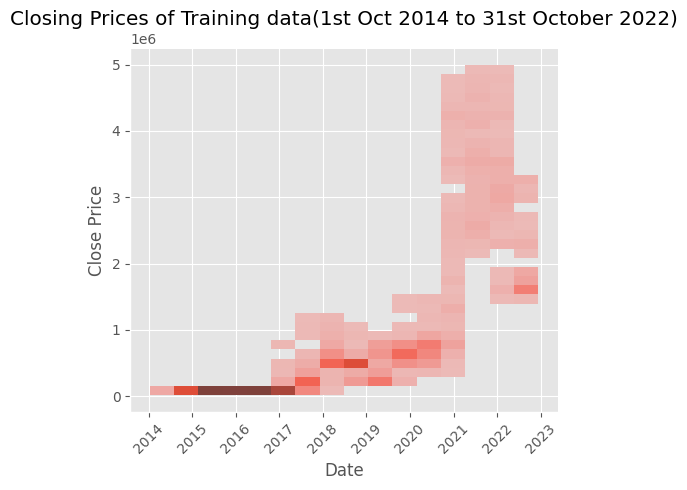

In [20]:
sns.displot(data=train,x=train.index ,y='Close')
#index=date
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Closing Prices of Training data(1st Oct 2014 to 31st October 2022)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

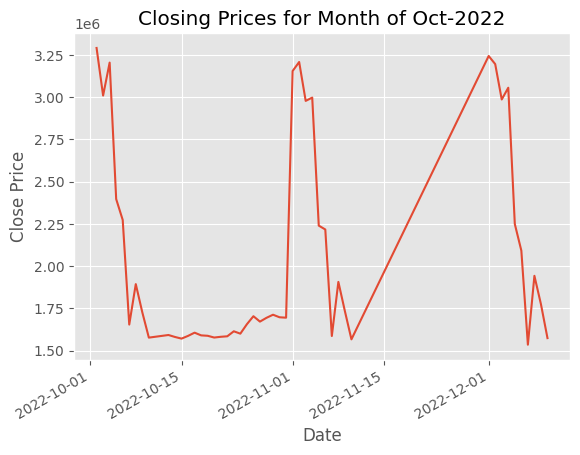

<Figure size 1000x600 with 0 Axes>

In [21]:
train['Close'].loc[(train.index > '2022-10-01')].plot()
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Closing Prices for Month of Oct-2022')
#plt.xticks(rotation=45)
plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.show()



# Uploading the testing data

In [22]:
#uploading the testing data
test = pd.read_csv('BTC-INR_TestingData.csv')
# data cleaning
test = test.iloc[::-1].reset_index(drop=True)
test.index = pd.to_datetime(test['Date'])
test.rename({'Price':'Close'},axis=1,inplace=True)
test.drop(['Date','Adj Close','Volume'],axis=1,inplace=True)
test = test[['High','Low','Open','Close']]
test = create_features(test)
#extended_df = train.append(test) # merging both train and test data and storing it in extended_df variable.
test

,High,Low,Open,Close,dayofweek,month,dayofyear
Date,,,,,,,
2023-11-06,2131411.000,2115753.250,2131411.000,2123924.000,0,11,310
2023-10-06,2207332.000,2172572.000,2186435.250,2182638.250,4,10,279
2023-09-06,2211380.000,2167331.250,2176799.500,2186624.250,2,9,249
2023-08-06,2255417.750,2160310.000,2247441.000,2176662.750,6,8,218
2023-07-06,2253886.000,2100692.250,2123204.000,2247699.750,3,7,187
...,...,...,...,...,...,...,...
2022-05-11,1757549.750,1728929.000,1732796.625,1744115.500,2,5,131
2022-04-11,1740263.750,1669184.750,1670900.500,1732993.125,0,4,101
2022-03-11,1687257.500,1665405.500,1671590.875,1671001.125,4,3,70


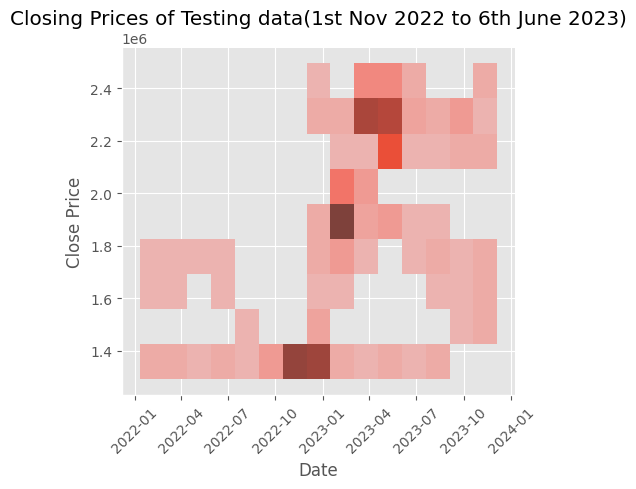

In [23]:
sns.displot(data=test,x=test.index ,y='Close')
#index=date
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Closing Prices of Testing data(1st Nov 2022 to 6th June 2023)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Close Price')

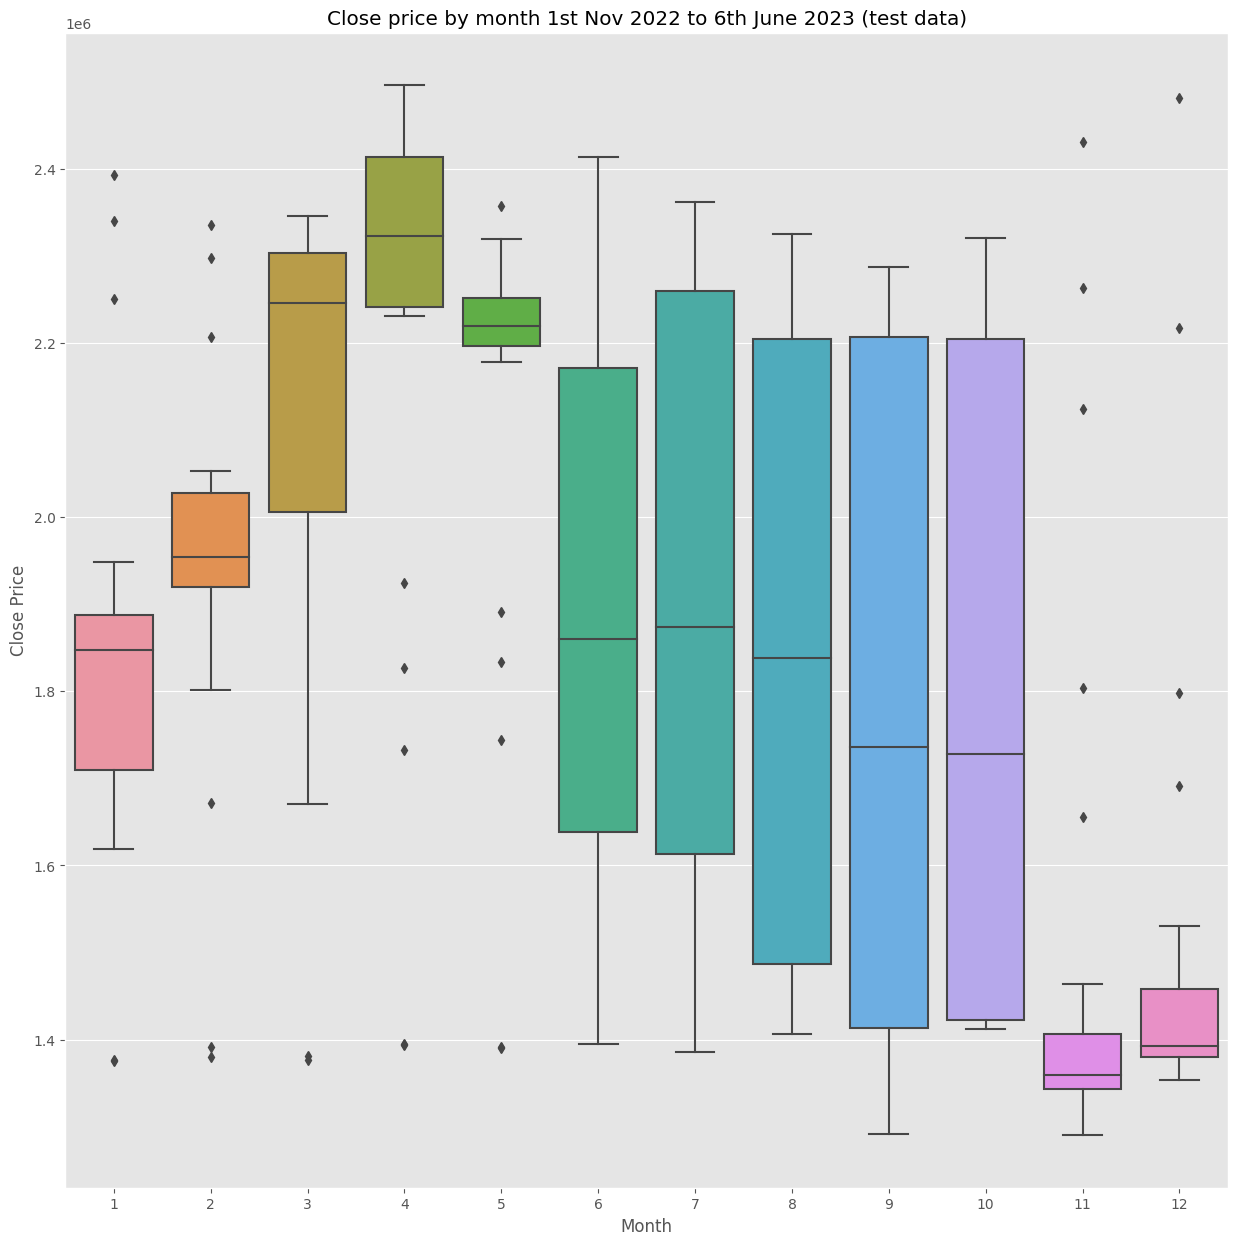

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
sns.boxplot(data=test,x='month',y='Close')
ax.set_title('Close price by month 1st Nov 2022 to 6th June 2023 (test data)')
ax.set_xlabel('Month')
ax.set_ylabel('Close Price')
#11-12 indicates months of 2021 while others indicate those of 2023

#summarization:
#diamonds: outliers
#horizontal line inside box: median
#box: IQR(interquartile range) q3(75%)-q1(25%)


# Creating the model

In [28]:
# since we using "High" ,"Low" and "Open" features, its not considered time-series forecasting,
# but we'll still use our time-series features regardless of it's impact on the model.
FEATURES = ['High','Low','Open','dayofweek','month','dayofyear']
TARGET = 'Close'

In [29]:
xtrain = train[FEATURES]#training data: high low
ytrain = train[TARGET]#training data: close

xtest = test[FEATURES]#testingdata: high low
ytest = test[TARGET]#testing data: close

In [ ]:
#xgbregressor: booster regression model
params = { 'max_depth': [3,4,5,6],
           'learning_rate': [0.01, 0.05, 0.1],#lower the rate so it dosent overfit too quickly
           'n_estimators': [100, 500, 1000], #how many trees this algo will create
           'colsample_bytree': [0.3, 0.7],
           'early_stopping_rounds':[20,50,100],
           'objective':['reg:squarederror']}

# Splitting into training and validation sets
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

xgbr1 = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr1,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)

clf.fit(xtrain, ytrain, eval_set=[(xval, yval)], verbose=False)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
xgbr = xgb.XGBRegressor(**clf.best_params_, seed = 20)
xgbr.fit(xtrain, ytrain, eval_set=[(xval, yval)], verbose=100)

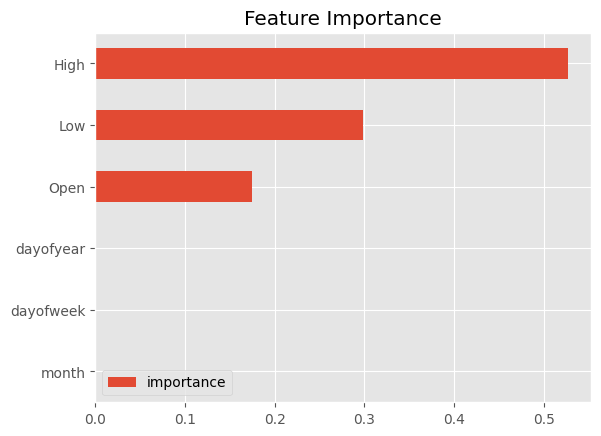

In [ ]:
# making a feature importance dataframe and plot it to visualize the impact of each feature on the model.
fi = pd.DataFrame(data=xgbr.feature_importances_,
             index=xgbr.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Creating final file having Original closing values and Predicted values

In [ ]:
# adding the prediction column to the test data, then merging it with the entire dataframe to visually compare results.
finalCSV = pd.read_csv('BTC-INR.csv')
finalCSV = finalCSV.iloc[::-1].reset_index(drop=True)

finalCSV['predictions'] = xgbr.predict(xtest)
finalCSV.index = pd.to_datetime(finalCSV['Date'])
finalCSV.drop(['S. No.','Date','Adj Close','Volume'],axis=1,inplace=True)
#finalCSV=finalCSV[['Close',['predictions']]]
#finalCSV.drop(['Date'])
# extended_df = extended_df.merge(test[['predictions']], how='left', left_index=True, right_index=True)
# extended_df.tail(30)

finalCSV = finalCSV.merge(finalCSV[['predictions']], how='left', left_index=True, right_index=True)
finalCSV

# columndeete=['Date']
# finalCSV=finalCSV.drop(columndeete, axis=1)
# finalCSV

,Open,High,Low,Close,predictions_x,predictions_y
Date,,,,,,
2023-06-06,2123586.000,2150642.750,2100949.750,2148147.500,2148796.500,2148796.500
2023-06-05,2230942.750,2258453.250,2222134.500,2234883.500,2252224.000,2252224.000
2023-06-04,2245652.750,2251021.000,2221292.250,2230943.250,2256941.500,2256941.500
2023-06-03,2207037.500,2249899.750,2187931.500,2245427.500,2202101.750,2202101.750
2023-06-02,2250065.750,2260621.750,2202880.000,2206660.500,2234458.750,2234458.750
...,...,...,...,...,...,...
2022-11-05,1732796.625,1757549.750,1728929.000,1744115.500,1769280.625,1769280.625
2022-11-04,1670900.500,1740263.750,1669184.750,1732993.125,1689809.500,1689809.500
2022-11-03,1671590.875,1687257.500,1665405.500,1671001.125,1675734.875,1675734.875


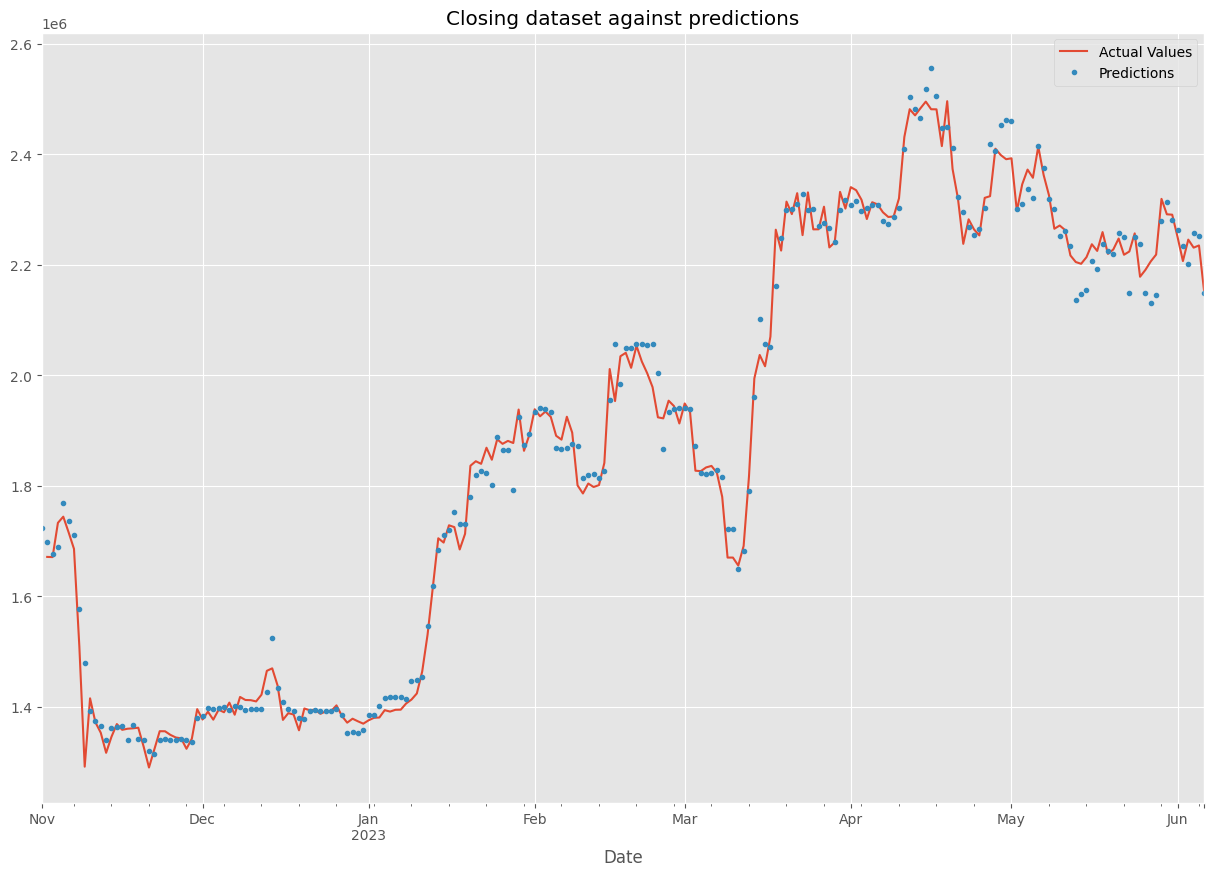

In [ ]:
# ax = extended_df['Close'].loc[extended_df.index > '2014-10-01'].plot(figsize=(15, 20))
# extended_df['predictions'].plot(ax=ax, style='.')
# plt.legend(['Actual Values', 'Predictions'])
# ax.set_title('Entire dataset against predictions')
# plt.show()
ax = finalCSV['Close'].loc[finalCSV.index > '2022-11-01'].plot(figsize=(15, 10))
finalCSV['predictions_y'].plot(ax=ax, style='.')
plt.legend(['Actual Values', 'Predictions'])
ax.set_title('Closing dataset against predictions')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(finalCSV['Close'], finalCSV['predictions_y']))
print(f'RMSE Score on Test set: {score:0.3f}')
#root mean squared error

RMSE Score on Test set: 34957.401


In [ ]:
finalCSV['error']=np.abs(test[TARGET] - finalCSV['predictions_y'])
finalCSV['date'] = test.index.date
print("Worst predictions")
finalCSV.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

Worst predictions


date
2022-11-09    188389.000
2023-02-16    102350.125
2023-03-18    102246.250
2023-04-27     94106.500
2023-01-28     85726.000
2023-02-24     79572.750
2023-02-23     77227.250
2023-05-27     75562.750
2023-04-16     75488.000
2023-05-23     74794.000
Name: error, dtype: float64

In [ ]:
print("Best predictions")
finalCSV.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

Best predictions


date
2022-12-25     409.750
2023-06-06     649.000
2022-12-21     662.875
2022-12-22     922.000
2023-03-29     922.750
2022-12-24    1112.750
2023-01-13    1117.000
2022-12-27    1299.000
2023-05-06    1484.000
2023-04-06    1539.000
Name: error, dtype: float64

In [ ]:
finalCSV['error']=np.abs(finalCSV[TARGET] - finalCSV['predictions_y'])
finalCSV = finalCSV.merge(finalCSV[['error']], how='left', left_index=True, right_index=True)

# Predict Price for any Date

In [ ]:
#finalCSV.groupby(['Date'])['error_y'].mean().sort_values(ascending=True)

# columndeete=['error_x','error_y']
# finalCSV=finalCSV.drop(columndeete, axis=1)

Date='Date'
valuecolumn_name='predictions_y'
ogvaluecolumn_name='Close'
errorcolumn_name='error_y'
flag=True

avgError = finalCSV[errorcolumn_name].mean()
maxError = finalCSV[errorcolumn_name].max()
minError = finalCSV[errorcolumn_name].min()

prediction_date=input('To predict BTCPrice on any date, \nEnter that date in yyyy-mm-dd format: ')
ispresent= prediction_date in finalCSV.index

if ispresent:

  value = finalCSV.loc[prediction_date, valuecolumn_name]
  ogvalue= finalCSV.loc[prediction_date, ogvaluecolumn_name]
  errorofDate=finalCSV.loc[prediction_date, errorcolumn_name]

  print(f'\nThe original BTC price on {prediction_date} was Rs. {ogvalue}.')
  print(f'The predicted BTC Price on {prediction_date} was Rs. {value}.')
  print(f'\nThe error value(Difference between Actual price and Predicted price) is: {value-ogvalue}.')

  # to judge nature of prediction
  if errorofDate == maxError:
    print('\nThe predicted BTC price can be said to be NOT accurate is worst prediction.')
  if errorofDate == minError:
    print('\nThe predicted BTC price can be said to be fairly accurate and is best prediction. ')
  if errorofDate <= avgError and errorofDate >= minError :
    print('\nThe predicted BTC price can be said to be accurate. \nSince the error at this date is less than the average error and more than Minimum error.')
  if errorofDate >= avgError and errorofDate <= maxError :
    print('\nThe predicted BTC price can be said to be accurate. \nSince the error at this date is more than the average error and less than Maximum error.')

  print('\nAverage Error: ', avgError)
  print('Minimum Error: ', minError)
  print('Maximum Error: ', maxError)

else:
  print('\nYou have entered the wrong date or it does not match the desired format. \nPlease check and enter the data again.')

To predict BTCPrice on any date, 
Enter that date in yyyy-mm-dd format: 2023-06-01

The original BTC price on 2023-06-01 was Rs. 2250169.0.
The predicted BTC Price on 2023-06-01 was Rs. 2262455.0.

The error value(Difference between Actual price and Predicted price) is: 12286.0.

The predicted BTC price can be said to be accurate. 
Since the error at this date is less than the average error and more than Minimum error.

Average Error:  25419.23394495413
Minimum Error:  409.75
Maximum Error:  188389.0


In [ ]:
finalCSV

NameError: ignored